## 导入依赖库

In [1]:
#os库是Python标准库，包含几百个函数,常用路径操作、进程管理、环境参数等几类；
#cv2是opencv的简称；
import os, cv2, random
#NumPy库使用Python进行科学计算，尤其是数据分析时，所用到的一个基础库。它是大量Python数学和科学计算包的基础
import numpy as np

# 画图工具
import matplotlib.pyplot as plt
#seaborn就是在matplotlib基础上面的封装，方便直接传参数调用
import seaborn as sns
%matplotlib inline
#Keras是TensorFlow官方的高层API。Keras是一个高层神经网络API
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.utils import np_utils
#sklearn是python的重要机器学习库，其中封装了大量的机器学习算法，如：分类、回归、降维以及聚类
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras import backend as K
K.set_image_data_format('channels_last') # 数据格式data_format设置为 NHWC

Using TensorFlow backend.


## 下载数据集

In [4]:
#下载数据压缩包，解压，然后清理压缩包。
from modelarts.session import Session
session = Session(username='***',  password='***', region_name='***')

if session.region_name == 'cn-north-1':
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz"
elif session.region_name == 'cn-north-4':
    bucket_path="modelarts-labs-bj4/notebook/DL_image_recognition/image_recognition.tar.gz"
else:
    print("请更换地区到北京一或北京四")

In [5]:
#查看是否已经由之前解压过的重复数据，如果有就不再次下载，直接使用之前已经下载好的
if not os.path.exists('./data'):
    session.download_data(
    bucket_path= bucket_path,
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Successfully download file modelarts-labs-bj4/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


## 读取数据集

In [6]:
DATA_DIR = './data/' # 数据集路径

# 目标缩放尺寸,读取数据集，并把图像resize到 128 * 128 大小。
ROWS = 128
COLS = 128
CHANNELS = 3
# os.listdir() 方法用于返回指定的文件夹包含的文件或文件夹的名字的列表。这个列表以字母顺序
image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌, shuffle() 方法将序列的所有元素随机排序。
random.shuffle(image_file_names)
#使用函数cv2.imread() 读入图像。这幅图像应该在此程序的工作路径，或者给函数提供完整路径，第二个参数是要告诉函数应该如何读取这幅图片。
#cv2.IMREAD_COLOR：读入一副彩**像。图像的透明度会被忽略，这是默认参数。
#cv2.IMREAD_GRAYSCALE：以灰度模式读入图像
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
# interpolation=cv2.INTER_CUBIC放大图像
def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
   #用count, ROWS, COLS, CHANNELS生成一个多维矩阵    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


## 给图片打标签

In [7]:
#我们根据图片名称包含的字符串给图片打标签。0表示cat，1表示dog。
num_train_samples = len(image_file_names)
num_classes = 2 # 类别数是2
labels = []

index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
        
# 把类别标签转换为onehot编码
labels = np_utils.to_categorical(labels, num_classes)
#即用one hot encoding方法将输出标签的向量（vector）转化为只在出现对应标签的那一列为1，其余为0的布尔矩阵

## 切分数据集

In [8]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)
#train_test_split来自scikit-learn, train_test_split函数用于将矩阵随机划分为训练子集和测试子集，并返回划分好的训练集测试集样本和训练集测试集标签。

## 查看猫狗的样本图片

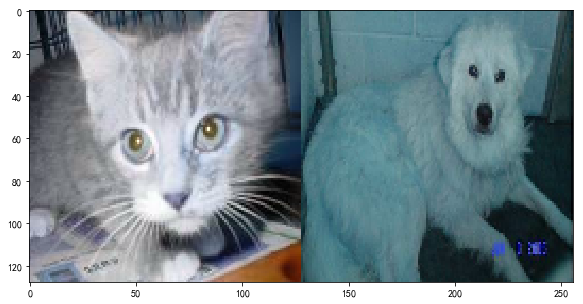

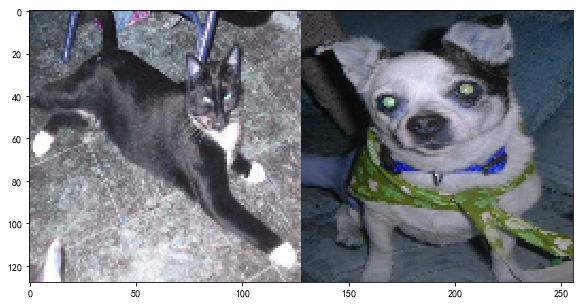

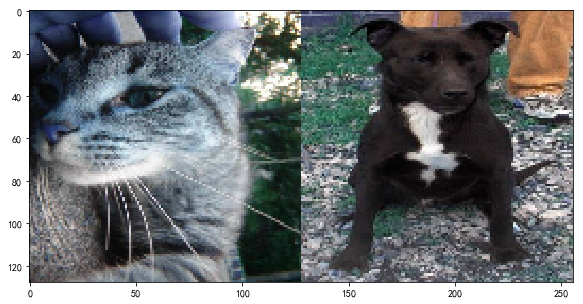

In [9]:
#查看猫狗的样本图片,这些图片是经过尺寸调整后的图片
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    #plt.imshow()函数负责对图像进行处理，并显示其格式，但是不能显示。其后跟着plt.show()才能显示出来。
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

##  构建神经网络

In [10]:
batch_size = 32 # 批大小
learning_rate = 1e-5 # 设置学习率为1e-5
optimizer = Adam(lr=learning_rate) # 优化器使用 Adam 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
objective = 'categorical_crossentropy' # loss 函数使用交叉熵

def load_model():
    # 这是一个模型参数随机初始化的模型，如果想要加载imagenet预训练模型，可以设置 weights='imagenet'
    base_model = VGG16(include_top=False, weights=None, input_shape=(ROWS, COLS, CHANNELS), pooling='avg')

    x = base_model.output
    
    # 修改base_model的模型输出层。这是一个二分类的问题。
    prediction_layer = Dense(2, activation='softmax')(x)
    
    # 组装成新的模型
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    
    # 模型编译
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = load_model()

## 模型结构概览

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## 模型训练

In [13]:
epochs = 15 # 训练轮数

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')   

def run_train():
    
    # 开始训练
    history = model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.2,  # 训练数据中，抽取20%的数据作为验证数据
        verbose=1,
        shuffle=True,
        callbacks=[early_stopping]) 
    return history

history = run_train()

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 15000 samples, validate on 3750 samples
Epoch 1/15
15000/15000 [==============================] - 41s 3ms/step - loss: 0.6469 - acc: 0.6179 - val_loss: 0.6007 - val_acc: 0.6720
Epoch 2/15
15000/15000 [==============================] - 27s 2ms/step - loss: 0.5726 - acc: 0.6978 - val_loss: 0.5395 - val_acc: 0.7277
Epoch 3/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.5100 - acc: 0.7457 - val_loss: 0.4922 - val_acc: 0.7656
Epoch 4/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.4706 - acc: 0.7735 - val_loss: 0.5003 - val_acc: 0.7603
Epoch 5/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.4243 - acc: 0.8036 - val_loss: 0.4243 - val_acc: 0.8045
Epoch 6/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3835 - acc: 0.8283 - val_loss: 0.4033 - val_acc: 0.8176
Epoch 7/15
15000/15000 [==============================] - 28s 2ms/step - loss: 0.3561 - acc: 0.8470 - val_loss: 0.3886 - val_acc:

## 保存模型

In [14]:
OUTPUT = 'output'

if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)

model.save(os.path.join(OUTPUT, 'model.h5'))

## 可视化训练过程

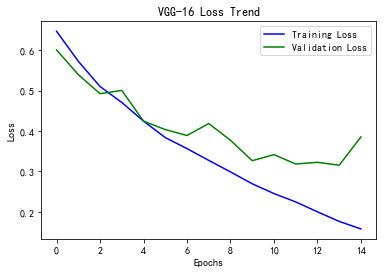

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

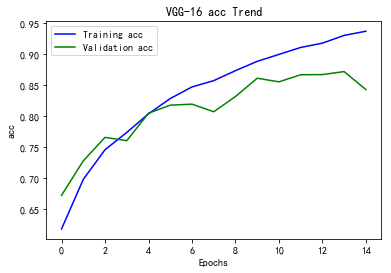

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

## 样本数据预测

In [17]:
predictions = model.predict(test_data, verbose=0)

I am 99.95% sure this is a Dog


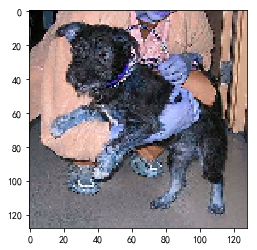

I am 95.54% sure this is a Dog


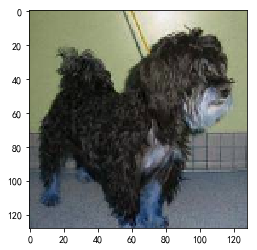

I am 100.00% sure this is a Dog


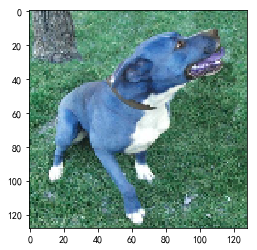

I am 98.50% sure this is a Cat


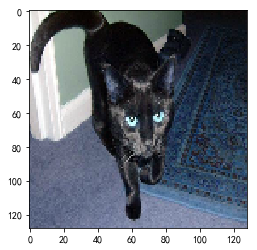

I am 93.49% sure this is a Cat


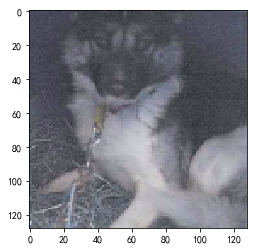

I am 95.89% sure this is a Dog


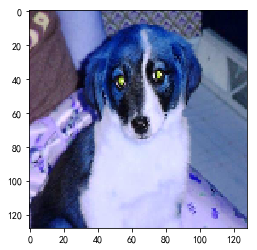

I am 97.30% sure this is a Cat


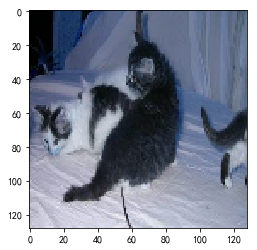

I am 58.14% sure this is a Cat


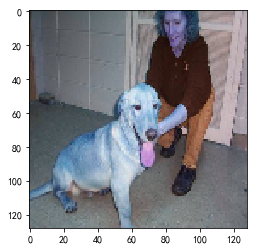

I am 96.96% sure this is a Dog


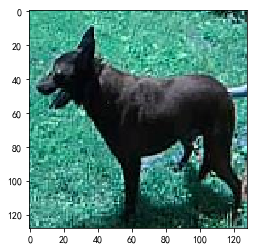

I am 73.27% sure this is a Cat


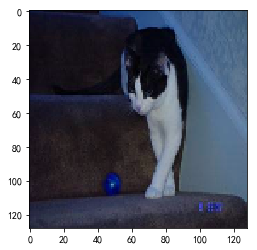

In [18]:
for i in range(0,10):
    p = predictions[i]
    
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

## 评估模型准确度

In [19]:
predictions_test_array = []
test_label_array = []

# 将onehot编码的数据进行格式转换
for p in predictions:
    if round(p[1]) == 1:
        predictions_test_array.append(1)
    else:
        predictions_test_array.append(0)
        
for t in test_label:
    if int(t[1]) == 1:
        test_label_array.append(1)
    else:
        test_label_array.append(0)
        
acc = accuracy_score(test_label_array, predictions_test_array)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.855040
